# Setpoint Reinforcement Learning
*Target a score for generalized control*

---

L’apprentissage par renforcement à permis de grande avancée dans le domaine du contrôle de système dynamique, aussi bien dans la robotique, les jeux vidéo, la navigation et dans la gestion de l’énergie, en particulier pour les systèmes non linéaires. Néanmoins, ce type d’apprentissage ne permet pas la généralisation à tous les systèmes dynamiques et parfois, des contrôleurs basés sur les modélisations du systèmes (MPC, PID, ToR, etc.) sont plus pertinents et plus **robustes** que des méthodes basées sur les données stochastiques (ex : optimisation heuristique). En particulier pour les cas où le système est linéaire et où la consigne à atteindre est bien connue, ce qui correspond à la plupart des cas dans les domaines électronique, mécanique et thermique. Nous introduisons ici une nouvelle méthode d’apprentissage par renforcement généralisable à tous les systèmes dynamiques linéaire où la consigne est connue et adaptative.

Concrètement, nous entrainons plusieurs algorithmes d'apprentissage par renforcement sur des environnements LTI ayant les specificitées suivantes :

**Observations :** Acquisition d'une variable $s$ de l'ensemble des états $S$ et actions $A$. Ensuite, nous appliquons la transformation suivante : $  (S,A) \rightarrow \left \{ a_{(i,t-1)}, s_{(i,t-1)}, s_{(i,t)}, s_{c(i,t+1)} \right \} $. Avec $s_{c(i,t+1)}$ la consigne de l'état choisi et $a_{(i,t-1)}$, l'action au temps précedent.

**Récompenses :** Système de récompense en fonction de l'écart par rapport à la consigne, doit suivre un critère $L_{1}, L_{2}$. La moyenne d'un controle aléatoire doit être positif.

La prise en compte de l'action et de l'etat à l'instant precedent est facultatif, mais permettent d'avoir une comprehension plus fine du système dynamique (linéaire ou non). L'etat à l'instant precedant permet d'intégrer l'information de variation et l'action permet de savoir s'il y a un effet d'inversion (ex : oscillation).

**Le modèle de simulation est le suivant :**

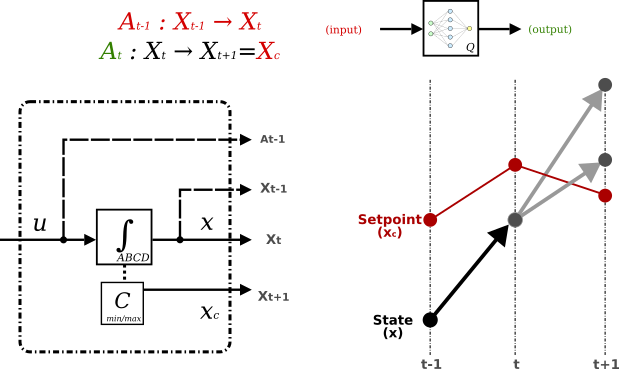


Nous obordons ici les premiers entrainement et test pour étudier la convergence de l'algorithme d'apprentissage sur notre modele d'environnement :

1.   Valeurs constante 1/2 tout au long de l'entrainement
2.   Valeurs constante variable / episodes
3.   Valeurs variables par épisodes

Les métriques sont {loss & n_epsiode de convergence & recompense cumulé}

Ensuite on compare l'efficacité pour chacun des cas spécifique, l'objectif est de s'avoir lequel généralise le plus.

On utilise l'algorithme DQN pour avoir un schéma d'équivalence avec Tout ou rien "modifié". En effet, nous considèrons que nous pouvons utiliser une approche naive pour controler un systeme linéaire avec ces informations, tel que l'action suivante peut s'ecrire quelquesoit $t$ :

$$a_{t} = sgn(a_{t-1}) \cdot sgn(s_{t} - s_{t-1}) \cdot sgn(s_{c, t+1} - s_{t})$$

> (en reflexion)



Ici, nous utilisons RLlib plutot que TorchRL car il est a ce jour plus abouti. Nous ne testerons pas les décisions transformer, mais des modèles *Transformers* et *RNN* sont inclus dans RLlib. Nous utiliserons ainsi des architectures LSTM et *GTrXL* pour tester par la suite.

In [ ]:
!pip3 install control
#!pip3 install gymnasium
!pip3 install ray[rllib]

In [2]:
import pylab as plt

*(masquer cette partie)*

---

## Code de l'environement

In [3]:
import gymnasium as gym
import numpy as np, control as ct
import pandas as pd
import scipy.ndimage as sm
import scipy.optimize as so

from gymnasium import spaces

class LinearSystemControl(gym.Env):
    def __init__(self, config={
                  "env_mode":1,
                  "update_setpoint":True,
                  "reset_X_start":True,
                  "tf":None,
                  "reset":True,
                  "isdiscrete":False,
                  "SpaceState":None,
                  "setpoint":None,
                  "env_config":None,
                  "modular":False,
                  "return_action":True,
                  "return_speed":False,
                  "order":3,
                  "v": [1,1],
                  "t":10,
                  "N":250}
                 ):
        self.config = config
        self.mode = config["env_mode"]
        self.definedSet = config["setpoint"]
        self._order = config["order"]
        self._isdiscrete = config["isdiscrete"]
        self._update_setpoint = config["update_setpoint"]
        self._reset = config["reset"]
        self._return_action = config["return_action"]
        self._reset_start = config["reset_X_start"]
        self._return_speed = config["return_speed"]
        self._rotate = config["modular"]
        self._max_episode_steps = config["N"]
        self.U = config["v"]
        self.T = config["t"]
        # sim
        self._elapsed_steps = 0
        self._life = 3
        self.previous_action = 0.
        # parameter
        if self._isdiscrete :
            self.action_space = spaces.Discrete(3)  # {-1, 0, 1}
        else :
            self.action_space = spaces.Box(low=-1., high=1., shape=(1,), dtype=np.float32) # [-1;1]
        self.dim_obs = 4 if self._return_action else 3
        # StateSpace
        self.ss = pd.Series({"i":0, "s":0, "A":np.array(1), "B":np.array(1), "C":np.array(1), "D":np.array(1)})  if not(isinstance(config["SpaceState"], pd.Series)) else config["SpaceState"]
        # IOSystem U={0,1}, X0=1
        self.dydt = []
        self.X_start = 0.
        self.time = np.linspace(0, self.T, self._max_episode_steps)
        if config["tf"] == None :
          self.sys = self.define_LinearIO(self.ss)
        else :
          self.sys = self.generate_ss_from_tf(*config["tf"])
        # define setpoint
        self.set_setpoint()

    ############ Parameter Part
    def signal_generator(self, N, epsilon=0.05):
        a = (1 - 2*epsilon)
        # smoother
        s = np.random.randint(1,N//10)
        # random
        r = np.random.random(N)
        # smooth signal
        smooth = sm.gaussian_filter1d(r, s)
        n = a*(smooth - smooth.min())/(smooth.max() - smooth.min()) + epsilon
        return n

    def set_setpoint(self, epsilon=0.05):
        # mode : consigne (setpoint in  [0+a,1-a])
        if self.mode == 0 :
            if self.definedSet == None :
              self.setpoint = (self.setmin + self.setmax)/2.
            else :
              self.setpoint = self.definedSet
        elif self.mode == 1 :
            self.setpoint = np.random.uniform(self.setmin + 2*self.D, self.setmax - 2*self.D)
        else :
            consigne = self.signal_generator(self._max_episode_steps, epsilon=self.D) # def pour nb max iter
            self.all_setpoint = (self.setmax - self.setmin)*consigne + self.setmin
            self.setpoint = self.all_setpoint[self._elapsed_steps] # prends la derniere valeur

    def define_Boundary(self, sys, d=0.05) :
        # calculate boundary
        _, Y_g = ct.forced_response(sys, self.time, U=-1, X0=self.X_start)
        _, Y_h = ct.forced_response(sys, self.time, U=1, X0=self.X_start)
        # sign in limit --> for order sup 1, find zeros bounds for generalization (zeros = len(fsolve(Y_g - Y_h, [0, self._max_episode_steps])))
        self.sign = (1. if Y_h[-1] > Y_g[-1] else -1.)
        # boundary
        self.min, self.max = min(Y_g.min(), Y_h.min()), max(Y_g.max(),Y_h.max())
        # setpoint limit (squeeze theroem : g < f < h) --> NO
        self.setmin, self.setmax = min(np.median(Y_h), np.median(Y_g)), max(np.median(Y_h), np.median(Y_g))
        # apply
        #self.observation_space = spaces.Box(low=self.min, high=self.max, shape=(self.dim_obs,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.dim_obs,), dtype=np.float32)
        # basic error 10 %
        self.D = d*(self.setmax - self.setmin)

    ############ Model Part
    def generate_ss_from_tf(self, num=[1], den=[1,1], setpoint=1./2):
        self.setpoint = self.definedSet = setpoint
        # create system
        sys = ct.TransferFunction(num,den)
        sys = ct.tf2ss(sys)
        # extract parameter
        self.ss["A"], self.ss["B"], self.ss["C"], self.ss["D"] = sys.A, sys.B, sys.C, sys.D
        self.ss["i"], self.ss["s"] = 1, sys.nstates
        # bound and simulation parameter
        self.define_Boundary(sys)
        # save
        self._order = self.ss["s"]
        return sys

    def define_LinearIO(self, ss, d=0.05):
        if ss.i == 0 :
          ss["s"] = self._order
          sys = ct.rss(self._order)
          ss["A"], ss["B"], ss["C"], ss["D"] = sys.A, sys.B, sys.C, sys.D
        else :
          sys = ct.StateSpace(ss.A,ss.B,ss.C,ss.D)
          self._order = ss["s"]
        if self._reset_start :
          self.X_start = np.random.choice([-1.,0.,1.])
        # bound and simulation parameter
        self.define_Boundary(sys, d)
        return sys

    ############ Simulation Part
    def reset(self, seed=None, options=None):
        self._life = 3
        # re-init
        if self._reset :
          self.sys = self.define_LinearIO(self.ss)
        if self._update_setpoint :
          self.set_setpoint()
        # 1st step
        self._elapsed_steps, T = 0, self.time[0:2]
        T, Y, X = ct.forced_response(self.sys, T, U=self.U, X0=self.X_start, return_x=True)
        self.V = self.U
        # update
        self._elapsed_steps += 1
        self.X = X[:,1]
        self.previous_action = self.U[-1]
        #return <obs>
        if self._return_speed :
          self.dydt = [(Y[1] - Y[0]) / (T[1] - T[0])]
          obs = [[Y[0],self.dydt[0]],[Y[1],self.dydt[0]],[self.setpoint,0]]
          if self._return_action :
            obs = [[self.previous_action, 0]] + obs
        else :
          obs = [Y[0], Y[1], self.setpoint]
          if self._return_action :
            obs = [self.previous_action] + obs
        return np.array(obs), {}

    def step(self, action):
        done = False
        # continuous or discrete
        if self._isdiscrete :
            action = action - 1 # {0,1,2} --> {-1, 0, 1}
        else :
            action = float(action)
            if self._rotate :
              action = 1.5*np.sin(action)
            else :
              action = min(max(action,-1.5),1.5)
        # update input
        T = self.time[self._elapsed_steps:self._elapsed_steps+2]
        self.V = [self.V[-1], action]
        # calculate
        T, Y, X = ct.forced_response(self.sys, T, U=self.V, X0=self.X, return_x=True)
        # update output
        self._elapsed_steps += 1
        self.X = X[:,1]
        # reward : Custom reward with HubberLoss (setpoint(t))
        if Y[-1] > (self.setpoint - self.D/5.) and Y[-1] < (self.setpoint + self.D/5.) :
            reward = 1.
        elif Y[-1] > (self.setpoint - self.D) and Y[-1] < (self.setpoint + self.D) :
            reward = 0.5
        else :
            reward = 0.
        # outlimit
        if (Y[-1] < self.min) or (Y[-1] > self.max) :
            reward = -1.
            self._life -= 1.
            if self._life == 0 :
              reward = -10.
              done = True
        # limit
        if self._elapsed_steps == self._max_episode_steps - 1 :
            done = True
        # update setpoint
        setpoint = self.setpoint
        if self.mode == 2 :
          self.setpoint = self.all_setpoint[self._elapsed_steps]
        # new state (setpoint(t+1))
        if self._return_speed :
          self.dydt = [self.dydt[-1]] + [(Y[1] - Y[0]) / (T[1] - T[0])]
          dsdt = (self.setpoint - setpoint) / (T[1] - self.time[self._elapsed_steps])
          obs = [[Y[0],self.dydt[0]],[Y[1],self.dydt[1]],[self.setpoint, dsdt]]
          if self._return_action :
            dadt = (action - self.previous_action) / (T[1] - self.time[self._elapsed_steps])
            obs = [[action, dadt]] + obs
        else :
          obs = [Y[0], Y[1], self.setpoint]
          if self._return_action :
            obs = [action] + obs
        state = np.array(obs)
        # update action
        self.previous_action = action
        # return <obs>, <reward: float>, <done: bool>, <info: dict>
        info = {}
        return state, reward, done, done, info

Pour un guide d'utilisation de RLlib, voir le lien suivant : https://docs.ray.io/en/latest/rllib/rllib-training.html

*(masquer cette partie)*

---

## Train


In [4]:
od1_config = {
    "env_mode":0,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":False,
    "isdiscrete":True, #False
    "SpaceState":None,
    "tf": ([1],[1,1],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":3,
    "v": [1,1],
    "t":10,
    "N":250
}

od1_config_m1_ppo = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":False,
    "isdiscrete":False,
    "SpaceState":None,
    "tf": ([1],[1,1],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":3,
    "v": [1,1],
    "t":10,
    "N":250
}

lti1_config_m1_ppo = {
    "env_mode":1,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":True,
    "isdiscrete":False,
    "SpaceState":None,
    "tf": None,
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":1,
    "v": [1,1],
    "t":10,
    "N":250
}

### Tout-ou-Rien "généralisé naïf"

In [7]:
# Create the Gym environment
env = LinearSystemControl(lti1_config_m1_ppo)
# see Order 1
print(env.sys)
# verif
_ = env.reset()
env.sys

<LinearIOSystem>: sys[5]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (1): ['x[0]']

A = [[-3.24176013]]

B = [[0.64875476]]

C = [[2.06209072]]

D = [[-0.]]



<LinearIOSystem:sys[6]:['u[0]']->['y[0]']>

**Rappel :**
$$a_{t} = sgn(a_{t-1}) \cdot sgn(s_{t} - s_{t-1}) \cdot sgn(s_{c, t+1} - s_{t})$$


[-1.         -0.60658137 -0.66765814 -0.67338357]


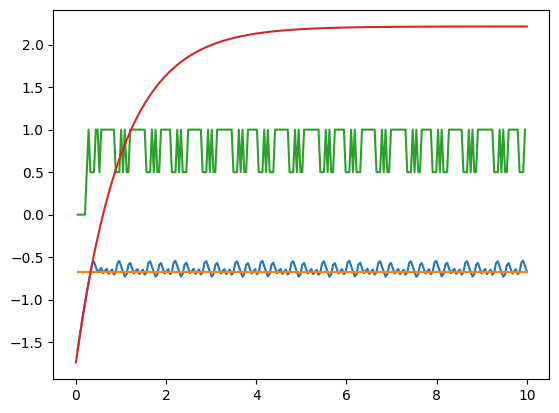

In [48]:
# mode
random = False
perturb = True
# simulation
state, _ = env.reset()
Y = [state[2:]]
R = []
for i in range(env._max_episode_steps-2) :
  if random :
    action = env.action_space.sample()
  else :
    #action = np.sign(state[0])*np.sign(state[2]-state[1])*np.sign(state[3]-state[2]) + env._isdiscrete
    action = env.sign*np.sign(state[3]-state[2]) + env._isdiscrete
    """
    if Y[-1][0] > env.setpoint :
      action = (-1)*env.sign
    else :
      action = env.sign + env._isdiscrete
    """
  if perturb :
    if np.random.random() > 0.999 :
      action = env.action_space.sample()
  state, reward, done, _, info = env.step(action)
  Y += [state[2:]]
  R += [reward]
  #if done : break
print(state)
# compare
T_OUT, Y_ = ct.forced_response(env.sys, env.time, U=1, X0=env.X_start)
# plot
plt.plot(T_OUT[1:], Y)
plt.plot(T_OUT[1:len(Y)], R)
plt.plot(T_OUT, Y_)
plt.show()

### RLLib

In [ ]:
import ray
#ray.shutdown()
ray.init()

2023-12-22 12:30:13,222	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.9.0


In [ ]:
from ray.rllib.algorithms import dqn, ppo

#algo = dqn.DQN(env=LinearSystemControl, config={"env_config": od1_config, "num_workers": 1})
#algo = ppo.PPO(env=LinearSystemControl, config={"env_config": od1_config_m1_ppo, "num_workers": 1})
algo = ppo.PPO(env=LinearSystemControl, config={"env_config": lti1_config_m1_ppo, "num_workers": 1})

/usr/local/lib/python3.10/dist-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
/usr/local/lib/python3.10/dist-packages/flax/linen/activation.py:36: DeprecationWarning: jax.nn.normalize is deprecated. Use jax.nn.standardize instead.
  from jax.nn import normalize
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
2023-12-22 12:30:29,460	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='<class '__main__.LinearSystemControl'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class '__main__.LinearSystemControl'>').build()` instead. This will raise an error in the future!
/usr/local/lib/python3

In [ ]:
from tqdm import tqdm

N = 200
for i in tqdm(range(N//4)):
  result = algo.train()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 50/50 [17:04<00:00, 20.48s/it]


In [ ]:
from ray.tune.logger import pretty_print

checkpoint_dir = algo.save().checkpoint.path
print(f"Checkpoint saved in directory {checkpoint_dir}")

beautiful_result = pretty_print(result)
print(beautiful_result)

Checkpoint saved in directory /tmp/tmpmqpoklg2
agent_timesteps_total: 200000
connector_metrics:
  ObsPreprocessorConnector_ms: 0.0073719024658203125
  StateBufferConnector_ms: 0.005463361740112305
  ViewRequirementAgentConnector_ms: 0.1466236114501953
counters:
  num_agent_steps_sampled: 200000
  num_agent_steps_trained: 200000
  num_env_steps_sampled: 200000
  num_env_steps_trained: 200000
custom_metrics: {}
date: 2023-12-22_12-47-44
done: false
episode_len_mean: 246.12
episode_media: {}
episode_reward_max: 211.5
episode_reward_mean: 30.67
episode_reward_min: -9.5
episodes_this_iter: 16
episodes_total: 838
hostname: 043e84ce952e
info:
  learner:
    default_policy:
      custom_metrics: {}
      diff_num_grad_updates_vs_sampler_policy: 464.5
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.02669677734374999
        cur_lr: 5.0000000000000016e-05
        entropy: 1.362027930667103
        entropy_coeff: 0.0
        grad_gnorm: 3.9404383938799623
        kl: 0

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
from ray.rllib.algorithms.algorithm import Algorithm
#algo_ = Algorithm.from_checkpoint("/content/drive/MyDrive/Colab Notebooks/order1_m0_rllib_test") # BUG ?
algo_ = algo

[-0.02230036 -0.00283023 -0.00173889 -0.00802786]


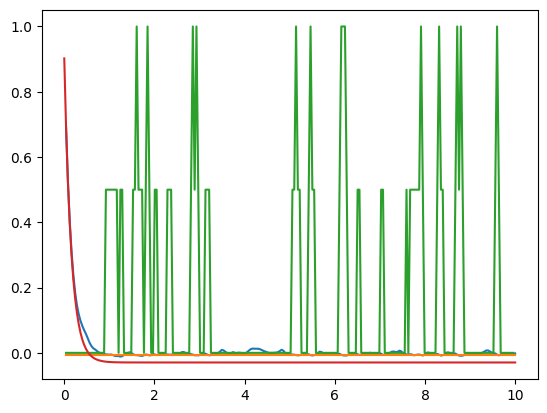

In [ ]:
# simulation
state, _ = env.reset()
Y = [state[2:]]
R = []
for i in range(env._max_episode_steps-2) :
  action = algo_.compute_single_action(state)
  state, reward, done, _, info = env.step(action)
  Y += [state[2:]]
  R += [reward]
  if done : break
print(state)
# compare
T_OUT, Y_ = ct.forced_response(env.sys, env.time, U=1, X0=env.X_start)
# plot
plt.plot(T_OUT[1:], Y)
plt.plot(T_OUT[1:len(Y)], R)
plt.plot(T_OUT, Y_)
plt.show()

---

## Test

Nous avons entrainé un algorithme d'apprentissage sur le mode 0 de l'environnement avec une fonction de transfert simple. Nous testons l'efficacité de l'algorithme sur le mode 2 (non entrainé pour)

In [ ]:
action

array([-0.02230036], dtype=float32)

<LinearIOSystem>: sys[6]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (1): ['x[0]']

A = [[-0.3136692]]

B = [[0.47474013]]

C = [[-0.91501541]]

D = [[-0.98524016]]

[ 1.          0.18307141  0.20942512 -0.53358167]


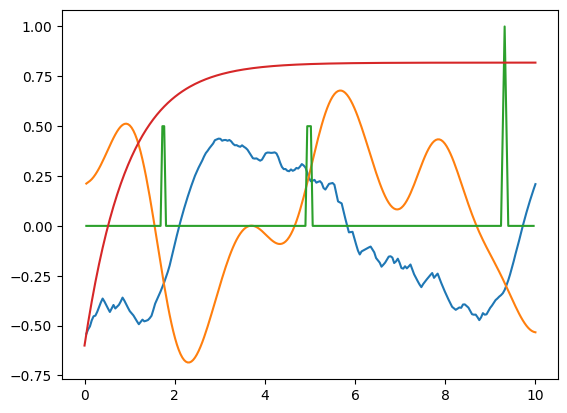

In [ ]:
# compare mode 0 trained --> mode 2 env
od1_config_m2_ppo = {
    "env_mode":2,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":False,
    "isdiscrete": False,
    "SpaceState":None,
    "tf": ([1],[1,1],1./2), #None
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":3,
    "v": [1,1],
    "t":10,
    "N":250
}

lti1_config_m2_ppo = {
    "env_mode":2,
    "update_setpoint":True,
    "reset_X_start":True,
    "reset":True,
    "isdiscrete":False,
    "SpaceState":None,
    "tf": None,
    "setpoint":None,
    "env_config":None,
    "modular":False,
    "return_action":True,
    "return_speed":False,
    "order":1,
    "v": [1,1],
    "t":10,
    "N":250
}

# Create the Gym environment
env_ = LinearSystemControl(lti1_config_m2_ppo)
print(env_.sys)
# simulation
state, _ = env_.reset()
Y = [state[2:]]
R = []
for i in range(env._max_episode_steps-2) :
  action = algo_.compute_single_action(state)
  state, reward, done, _, info = env_.step(action)
  Y += [state[2:]]
  R += [reward]
  if done : break
print(state)
# compare
T_OUT, Y_ = ct.forced_response(env_.sys, env_.time, U=1, X0=env_.X_start)
# plot
plt.plot(T_OUT[1:], Y)
plt.plot(T_OUT[1:len(Y)], R)
plt.plot(T_OUT, Y_)
plt.show()


**Résultat obtenu via un precedant workers :**

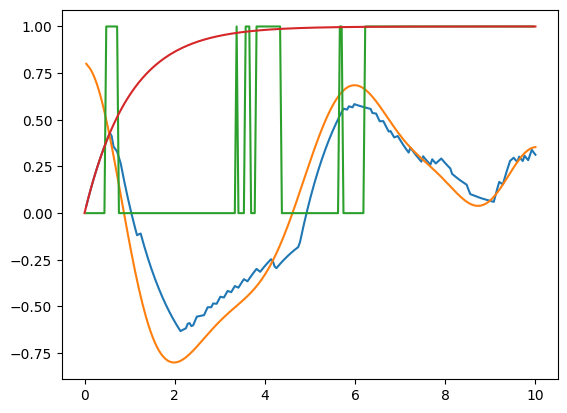

Avec surprise, on observe qu'un modèle entrainé sur une seul consigne peut arriver à intégrer la variation de la consigne. Néanmoins, des tests bas niveau directemet entrainé sur PyTorch ou d'autre entrenement ne montre pas toujours les mêmes resultats.

**Résultat obtenu via l'algorithme DQN sur PyTorch :**    



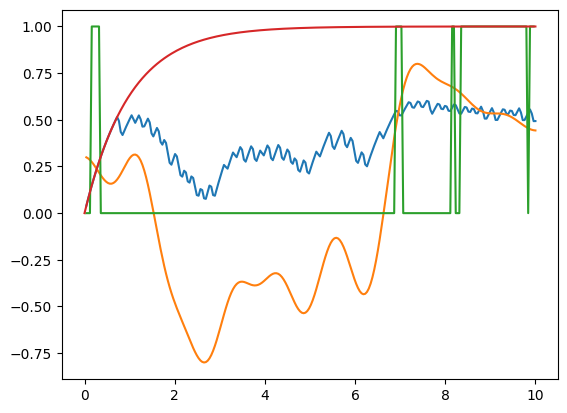


### Action Phase Space

#### Tout ou rien

In [ ]:
pA_, pS_, aS_, dS_, nA_ = [], [], [], [], []
# previous_action, previous_state, actual_state, desired_state, next_action
for i in tqdm(range(100)) :
  state, _ = env_.reset()
  for i in range(env_._max_episode_steps-2) :
    if state[2] > env_.setpoint :
      action = (-1)*env_.sign + env_._isdiscrete
    else :
      action = env_.sign + env_._isdiscrete
    state, reward, done, _, info = env_.step(action)
    pA_ += [state[0]]
    pS_ += [state[1]]
    aS_ += [state[2]]
    dS_ += [state[3]]
    nA_ += [action]
pA_, pS_, aS_, dS_, nA_ = np.array(pA_), np.array(pS_), np.array(aS_), np.array(dS_), np.array(nA_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


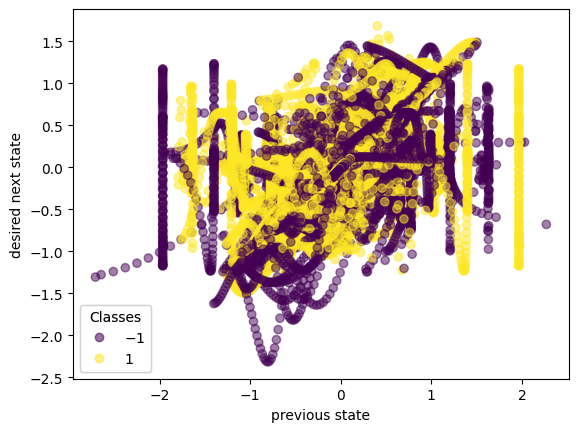

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(pS_, dS_, c=nA_- env_._isdiscrete, alpha=0.5)
# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),loc="lower left", title="Classes")
ax.add_artist(legend)
plt.xlabel("previous state")
plt.ylabel("desired next state")
plt.show()

Les résultats pour un Tout-ou-Rien sont ceux attendu pour une consigne adaptative d'un système linéaire d'ordre 1.

#### Model trained

In [ ]:
pA, pS, aS, dS, nA = [], [], [], [], []
# previous_action, previous_state, actual_state, desired_state, next_action
for i in tqdm(range(100)) :
  state, _ = env_.reset()
  for i in range(env_._max_episode_steps-2) :
    action = algo_.compute_single_action(state)
    state, reward, done, _, info = env_.step(action)
    pA += [state[0]]
    pS += [state[1]]
    aS += [state[2]]
    dS += [state[3]]
    nA += [action]
pA, pS, aS, dS, nA = np.array(pA), np.array(pS), np.array(aS), np.array(dS), np.array(nA)

100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


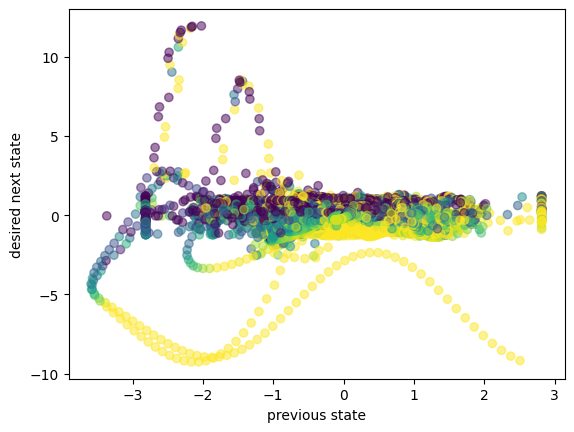

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(pS, dS, c=nA-1, alpha=0.5)
# produce a legend with the unique colors from the scatter
#legend = ax.legend(*scatter.legend_elements(),loc="lower left", title="Classes")
#ax.add_artist(legend)
plt.xlabel("previous state")
plt.ylabel("desired next state")
plt.show()

Les résultats semble montrer que le modèle à été entrainé sur une consigne constante, en particulier avec l'asymétrie du nuage de point (Comme on a un LTI d'ordre 1 identique tout au long de l'entrainement, on s'attend à une symetrie de la commande).


**Résultat obtenu via un precedant workers :**

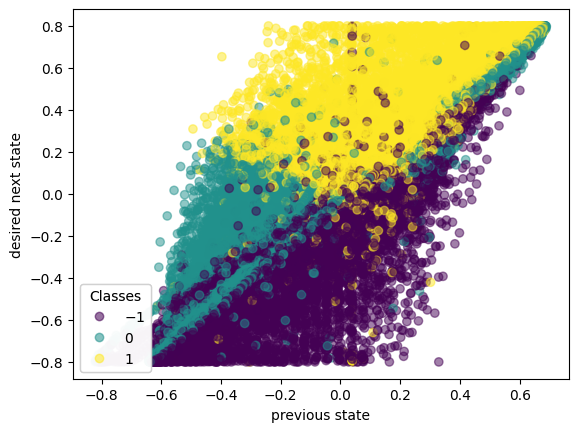